# **1. Model Averaging Ensemble**

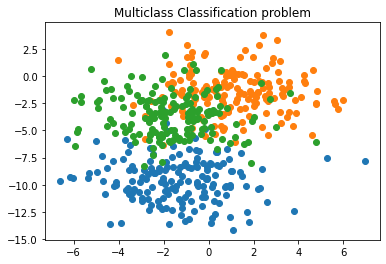

In [3]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot for each class value

for class_value in range(3):
  # select indices of points with the class label
  row_ix = np.where(y == class_value)
  # scatter plot for points with a different color
  plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show plot
plt.title("Multiclass Classification problem")
plt.show()

## 1.1. MLP Model for Multiclass Classification

Train: 0.840, Test: 0.757


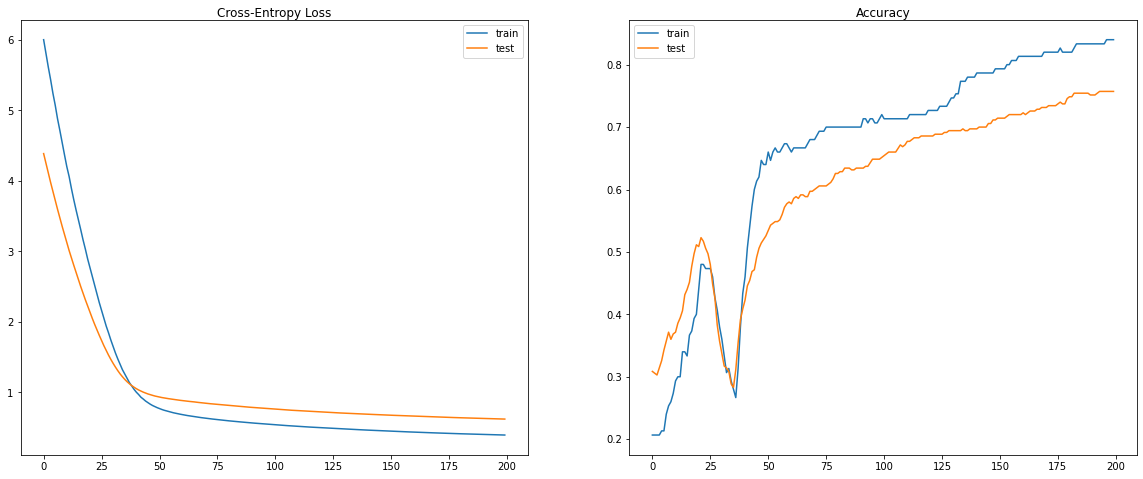

In [5]:
# fit high variance mlp on blobs classification problem
from sklearn.datasets import make_blobs
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(15, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# seed
np.random.seed(42)
tf.random.set_seed(42)

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0) 
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss learning curves
plt.figure(figsize = (20,8))
plt.subplot(121)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy learning curves
plt.subplot(122)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## 1.2. High Variance of MLP Model

> 0.757
> 0.751
> 0.783
> 0.737
> 0.751
> 0.769
> 0.800
> 0.797
> 0.786
> 0.706
> 0.786
> 0.783
> 0.740
> 0.783
> 0.794
> 0.771
> 0.757
> 0.780
> 0.760
> 0.760
> 0.729
> 0.766
> 0.763
> 0.749
> 0.723
> 0.786
> 0.769
> 0.766
> 0.771
> 0.757
Scores Mean: 0.764, Standard Deviation: 0.022


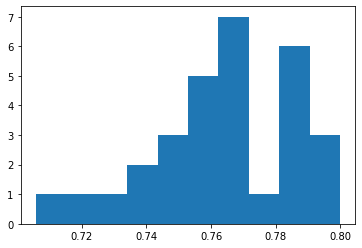

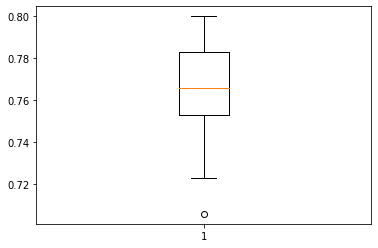

In [6]:
# demonstrate high variance of mlp model on blobs classification problem
from sklearn.datasets import make_blobs
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from numpy import mean
from numpy import std
from matplotlib import pyplot

# seed
np.random.seed(42)
tf.random.set_seed(42)

# fit and evaluate a neural net model on the dataset
def evaluate_model(trainX, trainy, testX, testy):
# define model
  model = Sequential()
  model.add(Dense(15, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax')) 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
  # fit model
  model.fit(trainX, trainy, epochs=200, verbose=0)
  # evaluate the model
  _, test_acc = model.evaluate(testX, testy, verbose=0)
  return test_acc

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# repeated evaluation
n_repeats = 30
scores = list()
for _ in range(n_repeats):
 score = evaluate_model(trainX, trainy, testX, testy) 
 print('> %.3f' % score)
 scores.append(score)

# summarize the distribution of scores
print('Scores Mean: %.3f, Standard Deviation: %.3f' % (mean(scores), std(scores))) 
# histogram of distribution
plt.hist(scores, bins=10)
plt.show()
# boxplot of distribution
plt.boxplot(scores)
plt.show()

## 1.3. Model Averaging Ensemble

1
> 0.757
2
> 0.757
3
> 0.766
4
> 0.757
5
> 0.760
6
> 0.766
7
> 0.769
8
> 0.769
9
> 0.766
10
> 0.766
11
> 0.771
12
> 0.771
13
> 0.769
14
> 0.769
15
> 0.771
16
> 0.771
17
> 0.771
18
> 0.774
19
> 0.774
20
> 0.771


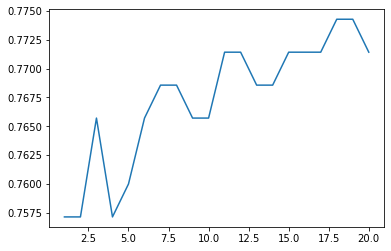

In [8]:
# model averaging ensemble and a study of ensemble size on test accuracy
from sklearn.datasets import make_blobs
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from numpy import array
from numpy import argmax

# seed
np.random.seed(42)
tf.random.set_seed(42)

# fit model on dataset
def fit_model(trainX, trainy):
# define model
  model = Sequential()
  model.add(Dense(15, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax')) 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
  # fit model
  model.fit(trainX, trainy, epochs=200, verbose=0)
  return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # sum across ensemble members
  summed = np.sum(yhats, axis=0)
  # argmax across classes
  result = argmax(summed, axis=1)
  return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
  # select a subset of members
  subset = members[:n_members]
  print(len(subset))
  # make prediction
  yhat = ensemble_predictions(subset, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)


# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
trainy = to_categorical(trainy)

# fit all models
n_members = 20
members = [fit_model(trainX, trainy) for _ in range(n_members)]

# evaluate different numbers of ensembles
scores = list()
for i in range(1, n_members+1):
  score = evaluate_n_members(members, i, testX, testy) 
  print('> %.3f' % score)
  scores.append(score)

# plot score vs number of ensemble members
x_axis = [i for i in range(1, n_members+1)]
plt.plot(x_axis, scores)
plt.show()

In [14]:
n_members = 20
members = [fit_model(trainX, trainy) for _ in range(n_members)]


yhats = [model.predict(testX) for model in members]
yhats = array(yhats)

In [11]:
yhats.shape

(20, 350, 3)

## 1.4. Reapeated evaluation of model averaging ensemble

In [ ]:
# repeated evaluation of model averaging ensemble on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
from numpy import argmax
from numpy import mean
from numpy import std
import numpy

# seed
np.random.seed(42)
tf.random.set_seed(42)

# fit model on dataset
def fit_model(trainX, trainy):
  # define model
  model = Sequential()
  model.add(Dense(15, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax')) 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
  # fit model
  model.fit(trainX, trainy, epochs=200, verbose=0)
  return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # sum across ensemble members
  summed = numpy.sum(yhats, axis=0)
  # argmax across classes
  result = argmax(summed, axis=1)
  return result

# evaluate ensemble model
def evaluate_members(members, testX, testy):
  # make prediction
  yhat = ensemble_predictions(members, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
trainy = to_categorical(trainy)

# repeated evaluation
n_repeats = 30
n_members = 5
scores = list()
for _ in range(n_repeats):
  # fit all models
  members = [fit_model(trainX, trainy) for _ in range(n_members)] # evaluate ensemble
  score = evaluate_members(members, testX, testy)
  print('> %.3f' % score)
  scores.append(score)
# summarize the distribution of scores
print('Scores Mean: %.3f, Standard Deviation: %.3f' % (mean(scores), std(scores)))

> 0.760
> 0.771
> 0.783
> 0.766
> 0.746
> 0.777
> 0.783
> 0.743
> 0.763
> 0.771
> 0.769
> 0.760
> 0.783
> 0.769
> 0.771
> 0.771
> 0.769
> 0.766
> 0.789
> 0.774
> 0.766
> 0.769
> 0.771
> 0.751
> 0.757
> 0.766
> 0.769
> 0.769
> 0.763
> 0.780
Scores Mean: 0.768, Standard Deviation: 0.010


## 1.5. Extensions

- **Average Class Prediction**. Update the example to average the class integer prediction instead of the class probability prediction and compare results.
- **Save and Load Models**. Update the example to save ensemble members to file, then load them from a separate script for evaluation.
- **Sensitivity of Variance**. Create a new example that performs a sensitivity analysis of the number of ensemble members on the standard deviation of model performance on the test set over a given number of repeats and report the point of diminishing returns.

# **2. Weighted Average Ensemble**

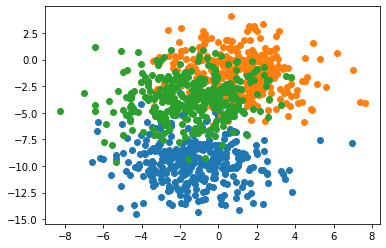

In [ ]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot for each class value
for class_value in range(3):
  # select indices of points with the class label
  row_ix = where(y == class_value)
  # scatter plot for points with a different color
  pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
 # show plot
pyplot.show()

## 2.1. Multilayer Perceptron Model

Train: 0.830, Test: 0.817


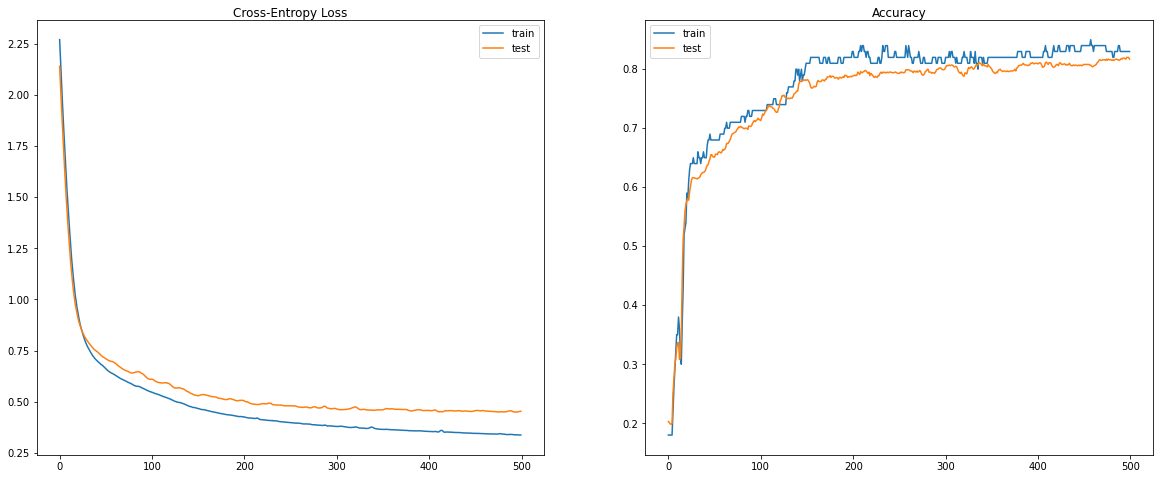

In [ ]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# seed
np.random.seed(42)
tf.random.set_seed(42)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2) 
# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
pyplot.figure(figsize = (20,8))
pyplot.subplot(121)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(122)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

## 2.2. Model Averaging Ensemble

> 1: single=0.817, ensemble=0.817
> 2: single=0.817, ensemble=0.817
> 3: single=0.818, ensemble=0.814
> 4: single=0.812, ensemble=0.815
> 5: single=0.814, ensemble=0.817
> 6: single=0.815, ensemble=0.818
> 7: single=0.812, ensemble=0.818
> 8: single=0.817, ensemble=0.819
> 9: single=0.821, ensemble=0.818
> 10: single=0.818, ensemble=0.818
Accuracy 0.816 (0.003)


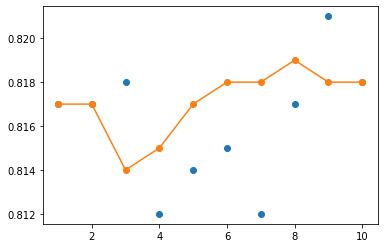

In [ ]:
# model averaging ensemble for the blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax

# seed
np.random.seed(42)
tf.random.set_seed(42)

# fit model on dataset
def fit_model(trainX, trainy):
  trainy_enc = to_categorical(trainy)
  # define model
  model = Sequential()
  model.add(Dense(25, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax')) 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # fit model
  model.fit(trainX, trainy_enc, epochs=500, verbose=0)
  return model


# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # sum across ensemble members
  summed = numpy.sum(yhats, axis=0)
  # argmax across classes
  result = argmax(summed, axis=1)
  return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
  # select a subset of members
  subset = members[:n_members]
  # make prediction
  yhat = ensemble_predictions(subset, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# fit all models
n_members = 10
members = [fit_model(trainX, trainy) for _ in range(n_members)]

# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
  # evaluate model with i members
  ensemble_score = evaluate_n_members(members, i, testX, testy)
  # evaluate the i'th model standalone
  testy_enc = to_categorical(testy)
  _, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
  # summarize this step
  print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score)) 
  ensemble_scores.append(ensemble_score)
  single_scores.append(single_score)

# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores))) 
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None') 
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## 2.3. Grid Search Weighted Average Ensemble

In [ ]:
# grid search for coefficients in a weighted average ensemble for the blobs problem
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from itertools import product

# seed
np.random.seed(42)
tf.random.set_seed(42)

# fit model on dataset
def fit_model(trainX, trainy):
  trainy_enc = to_categorical(trainy)
  # define model
  model = Sequential()
  model.add(Dense(25, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax')) 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # fit model
  model.fit(trainX, trainy_enc, epochs=500, verbose=0)
  return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # weighted sum across ensemble members
  summed = tensordot(yhats, weights, axes=((0),(0)))
  # argmax across classes
  result = argmax(summed, axis=1)
  return result

# evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
  # make prediction
  yhat = ensemble_predictions(members, weights, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)

# normalize a vector to have unit norm
def normalize(weights):
  # calculate l1 vector norm
  result = norm(weights, 1)
  # check for a vector of all zeros
  if result == 0.0:
    return weights
  # return normalized vector (unit norm)
  return weights / result

# grid search weights
def grid_search(members, testX, testy):
  # define weights to consider
  w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  best_score, best_weights = 0.0, None
  # iterate all possible combinations (cartesian product)
  for weights in product(w, repeat=len(members)):
    # skip if all weights are equal
    if len(set(weights)) == 1:
     continue
    # hack, normalize weight vector
    weights = normalize(weights)
    # evaluate weights
    score = evaluate_ensemble(members, weights, testX, testy)
    if score > best_score:
     best_score, best_weights = score, weights
     print('>%s %.3f' % (best_weights, best_score)) 
  return list(best_weights)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# fit all models
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]

# evaluate each single model on the test set
testy_enc = to_categorical(testy)
for i in range(n_members):
  _, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
  print('Model %d: %.3f' % (i+1, test_acc))

# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy) 
print('Equal Weights Score: %.3f' % score)

# grid search weights
weights = grid_search(members, testX, testy)
score = evaluate_ensemble(members, weights, testX, testy) 
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

Model 1: 0.817
Model 2: 0.817
Model 3: 0.818
Model 4: 0.812
Model 5: 0.814
Equal Weights Score: 0.817
>[0. 0. 0. 0. 1.] 0.814
>[0.         0.         0.         0.22222222 0.77777778] 0.815
>[0. 0. 1. 0. 0.] 0.818
>[0.         0.         0.66666667 0.         0.33333333] 0.819
>[0.  0.  0.8 0.  0.2] 0.820
>[0.         0.         0.88888889 0.11111111 0.        ] 0.821
>[0.         0.08333333 0.83333333 0.08333333 0.        ] 0.822


KeyboardInterrupt: ignored

## 2.4. Weighted Average MLP Ensemble

In [ ]:
# global optimization to find coefficients for weighted ensemble on blobs problem
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from scipy.optimize import differential_evolution
# fit model on dataset
def fit_model(trainX, trainy):
  trainy_enc = to_categorical(trainy)
  # define model
  model = Sequential()
  model.add(Dense(25, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax')) 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # fit model
  model.fit(trainX, trainy_enc, epochs=500, verbose=0)
  return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # weighted sum across ensemble members
  summed = tensordot(yhats, weights, axes=((0),(0)))
  # argmax across classes
  result = argmax(summed, axis=1)
  return result

# # evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
  # make prediction
  yhat = ensemble_predictions(members, weights, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)

# normalize a vector to have unit norm
def normalize(weights):
  # calculate l1 vector norm
  result = norm(weights, 1)
  # check for a vector of all zeros
  if result == 0.0:
    return weights
  # return normalized vector (unit norm)
  return weights / result

# loss function for optimization process, designed to be minimized
def loss_function(weights, members, testX, testy):
  # normalize weights
  normalized = normalize(weights)
  # calculate error rate
  return 1.0 - evaluate_ensemble(members, normalized, testX, testy)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# fit all models
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]

# evaluate each single model on the test set
testy_enc = to_categorical(testy)
for i in range(n_members):
  _, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
  print('Model %d: %.3f' % (i+1, test_acc))

# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)

# define bounds on each weight
bound_w = [(0.0, 1.0) for _ in range(n_members)]

# arguments to the loss function
search_arg = (members, testX, testy)

# global optimization of ensemble weights
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7) # get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)

# evaluate chosen weights
score = evaluate_ensemble(members, weights, testX, testy)
print('Optimized Weights Score: %.3f' % score)

## 2.5. Extensions
- **Parallelize Grid Search**. Update the grid search example to use the Joblib library to parallelize weight evaluation.
- **Implement Random Search**. Update the grid search example to use a random search of weight coefficients.
- **Try a Local Search**. Try a local search procedure provided by the SciPy library instead of the global search and compare performance.
- **Repeat Global Optimization**. Repeat the global optimization procedure multiple times for a given set of models to see if differing sets of weights can be found across the runs.

# **3. Resampling Ensembles**

- **Random Splits**. The dataset is repeatedly sampled with a random split of the data into train and test sets.
- **k-fold Cross-Validation**. The dataset is split into k equally sized folds, k models are trained and each fold is given an opportunity to be used as the holdout set where the model is trained on all remaining folds.
- **Bootstrap Aggregation**. Random samples are collected with replacement and examples not included in a given sample are used as the test set.


In [ ]:
# scatter plot of blobs dataset
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from numpy import where
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot for each class value
for class_value in range(3):
  # select indices of points with the class label
  row_ix = where(y == class_value)
  # scatter plot for points with a different color
  pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
   # show plot
pyplot.show()

## 3.1. Single Multilayer Perceptron Model

In [ ]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# seed
np.random.seed(42)
tf.random.set_seed(42)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2) # one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = int(0.9 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=50, verbose=0) 
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
pyplot.figure(figsize = (20,8))
pyplot.subplot(121)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(122)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

## 3.2. Random Splits Ensemble

In [ ]:
# random-splits mlp ensemble on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy

# seed
np.random.seed(42)
tf.random.set_seed(42)

# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
  # encode targets
  trainy_enc = to_categorical(trainy)
  testy_enc = to_categorical(testy)
  # define model
  model = Sequential()
  model.add(Dense(50, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax')) 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # fit model
  model.fit(trainX, trainy_enc, epochs=50, verbose=0)
  # evaluate the model
  _, test_acc = model.evaluate(testX, testy_enc, verbose=0)
  return model, test_acc

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # sum across ensemble members
  summed = numpy.sum(yhats, axis=0)
  # argmax across classes
  result = argmax(summed, axis=1)
  return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
  # select a subset of members
  subset = members[:n_members]
  # make prediction
  yhat = ensemble_predictions(subset, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)

# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2,
    random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]


# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
# split data
  trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.10)
  # evaluate model
  model, test_acc = evaluate_model(trainX, trainy, testX, testy) 
  print('>%.3f' % test_acc)
  scores.append(test_acc)
  members.append(model)

# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores)))

# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
  for i in range(1, n_splits+1):
  ensemble_score = evaluate_n_members(members, i, newX, newy)
  newy_enc = to_categorical(newy)
  _, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
  print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score)) 
  ensemble_scores.append(ensemble_score)
  single_scores.append(single_score)

# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores))) 
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None') 
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## 3.3. Cross-Validation Ensemble

In [ ]:
# cross-validation mlp ensemble on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy

# seed
np.random.seed(42)
tf.random.set_seed(42)

# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
  # encode targets
  trainy_enc = to_categorical(trainy)
  testy_enc = to_categorical(testy)
  # define model
  model = Sequential()
  model.add(Dense(50, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax')) 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # fit model
  model.fit(trainX, trainy_enc, epochs=50, verbose=0)
  # evaluate the model
  _, test_acc = model.evaluate(testX, testy_enc, verbose=0)
  return model, test_acc

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # sum across ensemble members
  summed = numpy.sum(yhats, axis=0)
  # argmax across classes
  result = argmax(summed, axis=1)
  return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
  # select a subset of members
  subset = members[:n_members]
  # make prediction
  yhat = ensemble_predictions(subset, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)

# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2,
    random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

# prepare the k-fold cross-validation configuration
n_folds = 10
kfold = KFold(n_folds, True, 1)

# cross validation estimation of performance
scores, members = list(), list()
for train_ix, test_ix in kfold.split(X):
  # select samples
  trainX, trainy = X[train_ix], y[train_ix]
  testX, testy = X[test_ix], y[test_ix]
  # evaluate model
  model, test_acc = evaluate_model(trainX, trainy, testX, testy) print('>%.3f' % test_acc)
  scores.append(test_acc)
  members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores))) # evaluate different numbers of ensembles on hold out set single_scores, ensemble_scores = list(), list()
for i in range(1, n_folds+1):
  ensemble_score = evaluate_n_members(members, i, newX, newy)
  newy_enc = to_categorical(newy)
  _, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
  print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score)) 
  ensemble_scores.append(ensemble_score)
  single_scores.append(single_score)

# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores))) 
x_axis = [i for i in range(1, n_folds+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None') 
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## 3.4. Bagging Ensemble

In [ ]:
# bagging mlp ensemble on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy

# seed
np.random.seed(42)
tf.random.set_seed(42)

# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
  # encode targets
  trainy_enc = to_categorical(trainy)
  testy_enc = to_categorical(testy)
  # define model
  model = Sequential()
  model.add(Dense(50, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax')) 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # fit model
  model.fit(trainX, trainy_enc, epochs=50, verbose=0)
  # evaluate the model
  _, test_acc = model.evaluate(testX, testy_enc, verbose=0)
  return model, test_acc

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # sum across ensemble members
  summed = numpy.sum(yhats, axis=0)
  # argmax across classes
  result = argmax(summed, axis=1)
  return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
  # select a subset of members
  subset = members[:n_members]
  # make prediction
  yhat = ensemble_predictions(subset, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)

# generate 2d classification dataset
dataX, datay = make_blobs(n_samples=55000, centers=3, n_features=2, cluster_std=2,
    random_state=2)
X, newX = dataX[:5000, :], dataX[5000:, :]
y, newy = datay[:5000], datay[5000:]

# multiple train-test splits: BAGGING
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
  # select indexes
  ix = [i for i in range(len(X))]
  train_ix = resample(ix, replace=True, n_samples=4500)
  test_ix = [x for x in ix if x not in train_ix]
  # select data
  trainX, trainy = X[train_ix], y[train_ix]
  testX, testy = X[test_ix], y[test_ix]
  # evaluate model
  model, test_acc = evaluate_model(trainX, trainy, testX, testy) print('>%.3f' % test_acc)
  scores.append(test_acc)
  members.append(model)
# summarize expected performance
print('Estimated Accuracy %.3f (%.3f)' % (mean(scores), std(scores))) 

# evaluate different numbers of ensembles on hold out set 
single_scores, ensemble_scores = list(), list()
for i in range(1, n_splits+1):
  ensemble_score = evaluate_n_members(members, i, newX, newy)
  newy_enc = to_categorical(newy)
  _, single_score = members[i-1].evaluate(newX, newy_enc, verbose=0)
  print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score)) 
  ensemble_scores.append(ensemble_score)
  single_scores.append(single_score)

# plot score vs number of ensemble members
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores))) 
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None') 
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## 3.5. Extesnsions
- **Single Model**. Compare the performance of each ensemble to one model trained on all available data.
- **CV Ensemble Size**. Experiment with larger and smaller ensemble sizes for the cross- validation ensemble and compare their performance.
- **Bagging Ensemble Limit**. Increase the number of members in the bagging ensemble to find the point of diminishing returns.

# **4. Horizontal Voting Ensembles**

In [ ]:

# scatter plot of blobs dataset
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from numpy import where
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot for each class value
for class_value in range(3):
  # select indices of points with the class label
  row_ix = where(y == class_value)
  # scatter plot for points with a different color
  pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
   # show plot
pyplot.show()

## 4.1. Multilayer Perceptron Model

In [ ]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# seed
np.random.seed(42)
tf.random.set_seed(42)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=1000, verbose=0) 
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
pyplot.figure(figsize = (20,8))
pyplot.subplot(121)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(122)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

## 4.2. Save Horizontal Models

In [ ]:
# save horizontal voting ensemble members during training
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from os import makedirs

# seed
np.random.seed(42)
tf.random.set_seed(42)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2) # one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# create directory for models
makedirs('models')
# fit model
n_epochs, n_save_after = 1000, 950
for i in range(n_epochs):
  # fit model for a single epoch
  model.fit(trainX, trainy, epochs=1, verbose=0)
  # check if we should save the model
  if i >= n_save_after:
model.save('models/model_' + str(i) + '.h5')

## 4.3. Make Horizontal Ensemble Predictions

In [ ]:
# load models and make predictions using a horizontal voting ensemble
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy

# seed
np.random.seed(42)
tf.random.set_seed(42)

# load models from file
def load_all_models(n_start, n_end):
  all_models = list()
  for epoch in range(n_start, n_end):
    # define filename for this ensemble
filename = 'models/model_' + str(epoch) + '.h5' # load model from file
model = load_model(filename)
# add to list of members all_models.append(model)
print('>loaded %s' % filename) return all_models
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # sum across ensemble members
  summed = numpy.sum(yhats, axis=0)
  # argmax across classes
  result = argmax(summed, axis=1)
  return result
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
  # select a subset of members
  subset = members[:n_members]
  # make prediction
  yhat = ensemble_predictions(subset, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# load models in order
members = load_all_models(950, 1000)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
  # evaluate model with i members
  ensemble_score = evaluate_n_members(members, i, testX, testy)
# evaluate the i'th model standalone
testy_enc = to_categorical(testy)
_, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
# summarize this step
print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score)) ensemble_scores.append(ensemble_score)
single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores))) # plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None') pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## 4.4. Extensions
- **Dataset Size**. Repeat the experiments with a smaller or larger sized dataset with a similar ratio of training to test examples.
- **Larger Ensemble**. Re-run the example with hundreds of final models and report the impact of the large ensemble sizes of accuracy on the test set.
- **Random Sampling of Models**. Re-run the example and compare the performance of ensembles of the same size with models saved over contiguous epochs to a random selection of saved models.

# **5. Snapshot Ensembles**

In [ ]:
# scatter plot of blobs dataset
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from numpy import where
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot for each class value
for class_value in range(3):
  # select indices of points with the class label
  row_ix = where(y == class_value)
  # scatter plot for points with a different color
  pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show plot
pyplot.show()

## 5.1. Multilayer Perceptron Model

In [ ]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot


# seed
np.random.seed(42)
tf.random.set_seed(42)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2) 
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0) # evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
pyplot.figure(figsize = (20,8))
pyplot.subplot(121)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(122)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

## 5.2. Cosine Annealing Learning Rate

In [ ]:
# mlp with cosine annealing learning rate schedule on blobs problem
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras import backend
from math import pi
from math import cos
from math import floor
from matplotlib import pyplot
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(Callback):
  # constructor
  def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
    self.epochs = n_epochs
    self.cycles = n_cycles
    self.lr_max = lrate_max
    self.lrates = list()
  # calculate learning rate for an epoch
  def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
    epochs_per_cycle = floor(n_epochs/n_cycles)
    cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
    return lrate_max/2 * (cos(cos_inner) + 1)
  # calculate and set learning rate at the start of the epoch
  def on_epoch_begin(self, epoch, logs=None):
    # calculate learning rate
    lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
    # set learning rate
    backend.set_value(self.model.optimizer.lr, lr)
    # log value
    self.lrates.append(lr)
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # define learning rate callback
n_epochs = 400
n_cycles = n_epochs / 50
ca = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, 0.01)
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=n_epochs,
    verbose=0, callbacks=[ca])
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0) _, test_acc = model.evaluate(testX, testy, verbose=0) print('Train: %.3f, Test: %.3f' % (train_acc, test_acc)) # plot learning rate
pyplot.plot(ca.lrates)
pyplot.show()
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40) pyplot.plot(history.history['loss'], label='train') pyplot.plot(history.history['val_loss'], label='test') pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40) pyplot.plot(history.history['acc'], label='train') pyplot.plot(history.history['val_acc'], label='test') pyplot.legend()
pyplot.show()


## 5.3. MLP Snapshot Ensemble

In [ ]:
# example of saving models for a snapshot ensemble
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras import backend
from math import pi
from math import cos
from math import floor
# snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
  # constructor
  def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
    self.epochs = n_epochs
    self.cycles = n_cycles
    self.lr_max = lrate_max
    self.lrates = list()
  # calculate learning rate for epoch
  def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
    epochs_per_cycle = floor(n_epochs/n_cycles)
    cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
    return lrate_max/2 * (cos(cos_inner) + 1)
  # calculate and set learning rate at the start of the epoch
  def on_epoch_begin(self, epoch, logs={}):
    # calculate learning rate
    lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
    # set learning rate
    backend.set_value(self.model.optimizer.lr, lr)
    # log value
    self.lrates.append(lr)
  # save models at the end of each cycle
  def on_epoch_end(self, epoch, logs={}):
    # check if we can save model
    epochs_per_cycle = floor(self.epochs / self.cycles)
    if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
     # save model to file
filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle) self.model.save(filename)
print('>saved snapshot %s, epoch %d' % (filename, epoch))
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# create snapshot ensemble callback
n_epochs = 500
n_cycles = n_epochs / 50
ca = SnapshotEnsemble(n_epochs, n_cycles, 0.01)
# fit model
model.fit(trainX, trainy, validation_data=(testX, testy), epochs=n_epochs, verbose=0,
    callbacks=[ca])

Load Models and Make Ensemble Prediction


In [ ]:
# load models and make a snapshot ensemble prediction
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
import numpy
# load models from file
def load_all_models(n_models):
  all_models = list()
  for i in range(n_models):
    # define filename for this ensemble
filename = 'snapshot_model_' + str(i + 1) + '.h5' # load model from file
model = load_model(filename)
# add to list of members
    all_models.append(model)
print('>loaded %s' % filename) return all_models
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # sum across ensemble members
  summed = numpy.sum(yhats, axis=0)
  # argmax across classes
  result = argmax(summed, axis=1)
  return result
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
  # select a subset of members
  subset = members[:n_members]
  # make prediction
  yhat = ensemble_predictions(subset, testX)
  # calculate accuracy
  return accuracy_score(testy, yhat)
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load models in order
members = load_all_models(10)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
  # evaluate model with i members
  ensemble_score = evaluate_n_members(members, i, testX, testy)
# evaluate the i'th model standalone
testy_enc = to_categorical(testy)
_, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
# summarize this step
print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score)) ensemble_scores.append(ensemble_score)
single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores))) # plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None') pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

## 5.4. Extensions
- Vary Cycle Length. Update the example to use a shorter or longer cycle length and compare results.
- Vary Maximum Learning Rate. Update the example to use a larger or smaller maximum learning rate and compare results.
- Update Learning Rate Per Batch. Update the example to calculate the learning rate per-batch instead of per-epoch.
- Repeated Evaluation. Update the example to repeat the evaluation of the model to confirm that the approach indeed leads to an improved performance over the final model on the blobs problem.
- Cyclic Learning Rate. Update the example to use a cyclic learning rate schedule and compare results.


# **6. Stacked Generalization Ensemble**

In [ ]:
# scatter plot of blobs dataset
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from numpy import where
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot for each class value
for class_value in range(3):
  # select indices of points with the class label
  row_ix = where(y == class_value)
  # scatter plot for points with a different color
  pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
 # show plot
pyplot.show()

## 6.1. Multilayer Perceptron Model

In [ ]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2) # one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0) 
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss learning curves
pyplot.figure(figsize = (20,8))
pyplot.subplot(121)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(122)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

## 6.2. Train and Save Sub-Models

In [ ]:
# example of saving sub-models for later use in a stacking ensemble
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from os import makedirs
# fit model on dataset
def fit_model(trainX, trainy):
# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax')) model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # fit model
  model.fit(trainX, trainy, epochs=500, verbose=0)
  return model
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :] trainy, testy = y[:n_train], y[n_train:]
# create directory for models makedirs('models')
# fit and save models
n_members = 5
for i in range(n_members):
# fit model
  model = fit_model(trainX, trainy)
# save model
filename = 'models/model_' + str(i + 1) + '.h5' model.save(filename)
print('>Saved %s' % filename)

## 6.3. Separate Stacking Model

In [ ]:
# stacked generalization with linear meta model on blobs dataset
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack
# load models from file
def load_all_models(n_models):
  all_models = list()
  for i in range(n_models):
    # define filename for this ensemble
filename = 'models/model_' + str(i + 1) + '.h5' # load model from file
model = load_model(filename)
# add to list of members all_models.append(model)
print('>loaded %s' % filename) return all_models
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
  stackX = None
  for model in members:
    # make prediction
    yhat = model.predict(inputX, verbose=0)
    # stack predictions into [rows, members, probabilities]
    if stackX is None:
     stackX = yhat
    else:
     stackX = dstack((stackX, yhat))
  # flatten predictions to [rows, members x probabilities]
  stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
  return stackX
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
  # create dataset using ensemble
  stackedX = stacked_dataset(members, inputX)
  # fit standalone model
model = LogisticRegression(solver='lbfgs', multi_class='multinomial') model.fit(stackedX, inputy)
return model
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
  # create dataset using ensemble
  stackedX = stacked_dataset(members, inputX)
  # make a prediction
  yhat = model.predict(stackedX)
  return yhat
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# load all models
n_members = 5
members = load_all_models(n_members) print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset for model in members:
testy_enc = to_categorical(testy)
_, acc = model.evaluate(testX, testy_enc, verbose=0) print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(members, model, testX) acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

## 6.4. Integrated Stacking Model

In [ ]:
# stacked generalization with neural net meta model on blobs dataset
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
# load models from file
def load_all_models(n_models):
  all_models = list()
  for i in range(n_models):
    # define filename for this ensemble
filename = 'models/model_' + str(i + 1) + '.h5' # load model from file
model = load_model(filename)
# add to list of members all_models.append(model)
print('>loaded %s' % filename) return all_models
# define stacked model from multiple member input models
def define_stacked_model(members):
  # update all layers in all models to not be trainable
  for i in range(len(members)):
    model = members[i]
    for layer in model.layers:
      # make not trainable
      layer.trainable = False
# rename to avoid 'unique layer name' issue
layer.name = 'ensemble_' + str(i+1) + '_' + layer.name # define multi-headed input
ensemble_visible = [model.input for model in members]
# concatenate merge output from each model ensemble_outputs = [model.output for model in members] merge = concatenate(ensemble_outputs)
hidden = Dense(10, activation='relu')(merge)
output = Dense(3, activation='softmax')(hidden)
model = Model(inputs=ensemble_visible, outputs=output)
# plot graph of ensemble
plot_model(model, show_shapes=True, to_file='model_graph.png')
# compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) return model
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
  # prepare input data
  X = [inputX for _ in range(len(model.input))]
  # encode output data
  inputy_enc = to_categorical(inputy)
  # fit model
  model.fit(X, inputy_enc, epochs=300, verbose=0)
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
  # prepare input data
  X = [inputX for _ in range(len(model.input))]
  # make prediction
  return model.predict(X, verbose=0)
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :] trainy, testy = y[:n_train], y[n_train:]
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset fit_stacked_model(stacked_model, testX, testy)
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, testX) yhat = argmax(yhat, axis=1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

# **7. Average Model Weights Ensemble**